In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import scpipeline

In [3]:
# other libs
import os, sys, csv,json,datetime,time,math,scipy.stats,collections,re;
from sklearn import preprocessing;
import numpy as np;
import pandas as pd;
import os.path;
import scanpy;
import scanpy.api as sc
sc.settings.set_figure_params(dpi=80)

### Pull data from the url

In [4]:
# Create a folder
!mkdir data

In [5]:
# Pull all the data from the url
!wget -O ./data/GSE135893_barcodes.tsv.gz "https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE135893&format=file&file=GSE135893%5Fbarcodes%2Etsv%2Egz"
!wget -O ./data/GSE135893_genes.tsv.gz "https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE135893&format=file&file=GSE135893%5Fgenes%2Etsv%2Egz"
!wget -O ./data/GSE135893_matrix.mtx.gz "https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE135893&format=file&file=GSE135893%5Fmatrix%2Emtx%2Egz"

--2020-02-15 22:42:31--  https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE135893&format=file&file=GSE135893%5Fbarcodes%2Etsv%2Egz
Resolving www.ncbi.nlm.nih.gov (www.ncbi.nlm.nih.gov)... 130.14.29.110
Connecting to www.ncbi.nlm.nih.gov (www.ncbi.nlm.nih.gov)|130.14.29.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 936873 (915K) [application/octet-stream]
Saving to: ‘./data/GSE135893_barcodes.tsv.gz’

./data/GSE135893_ba 100%[===================>] 914.92K  2.90MB/s    in 0.3s    

2020-02-15 22:42:32 (2.90 MB/s) - ‘./data/GSE135893_barcodes.tsv.gz’ saved [936873/936873]

--2020-02-15 22:42:32--  https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE135893&format=file&file=GSE135893%5Fgenes%2Etsv%2Egz
Resolving www.ncbi.nlm.nih.gov (www.ncbi.nlm.nih.gov)... 130.14.29.110
Connecting to www.ncbi.nlm.nih.gov (www.ncbi.nlm.nih.gov)|130.14.29.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 129668 (127K) [application/octet-stream]
Savin

In [6]:
# Unzip them
!mkdir ./data/pf_data
!gunzip < ./data/GSE135893_barcodes.tsv.gz > ./data/pf_data/barcodes.tsv
!gunzip < ./data/GSE135893_genes.tsv.gz > ./data/pf_data/genes.tsv
!gunzip < ./data/GSE135893_matrix.mtx.gz > ./data/pf_data/matrix.mtx

In [7]:
# Since I won't be able to read all the matrix data into my computer, so here is the way to undersample it. 
# You could skip this step if you are gonna use all the mtx data
!mv ./data/pf_data/matrix.mtx ./data/pf_data/matrix_all.bk # change the matrix file with all data to a backup file
!head -25000000 ./data/pf_data/matrix_all.bk > ./data/pf_data/matrix.mtx # only keep 25000000 rows (undersampling now)

# Now you need to open matrix.mtx, and change the second line
# 33694 220213 24825781 --> 33694 220213 24999998

### Read Data
To successfully to load the data, you will need to:
1. Rename *_matrix.mtx to matrix.mtx (done in the previous section)
2. Rename *_barcodes.tsv to barcodes.tsv (done in the previous section)
3. Reanme *_genes.tsv to genes.tsv, need to ensure the file have two columns (gene_id, gene_symbol). Otherwise, the readData function will break. So the following code is to create a fake gene ID. (done in the below section)

If you want percent_mito, you will need to turn on `self.data.obs['percent_mito'] = np.sum(self.data[:, mito_genes].X, axis=1)  / np.sum(self.data.X, axis=1)`

#### Fake the gene ID for genes.tsv

In [8]:
fake_gene_df = pd.read_csv('./data/pf_data/genes.tsv', header=None)

In [9]:
fake_gene_id = []
for i in range (0, len(fake_gene_df)):
    fake_gene_id.append('gene_' + str(i))

In [10]:
fake_gene_output_df = pd.DataFrame(fake_gene_id)

In [11]:
fake_gene_output_df[1] = fake_gene_df[0]

In [12]:
!mv ./data/pf_data/genes.tsv ./data/pf_data/genes.bk # back up the old genes.tsv file
fake_gene_output_df.to_csv('./data/pf_data/genes.tsv', sep='\t', index=None, header=None)

#### Start to read and preprocess the data

In [13]:
# read counts data from 10X V3 data (cell ranger V3 output) 
p =  scpipeline.ProcessPipline();

dataPath='./data/pf_data';  # the directory with the `.mtx` file

p.readData(dataPath)                            # read 10X '.mtx'data, compute mitochondra fraction, and create p.data 
p.data                                          # p.data: this is the data object we will use for QC    

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
filtered out 8255 genes that are detected in less than 1 cells


AnnData object with n_obs × n_vars = 220213 × 25439 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells'

normalizing counts per cell
    finished (0:00:00)


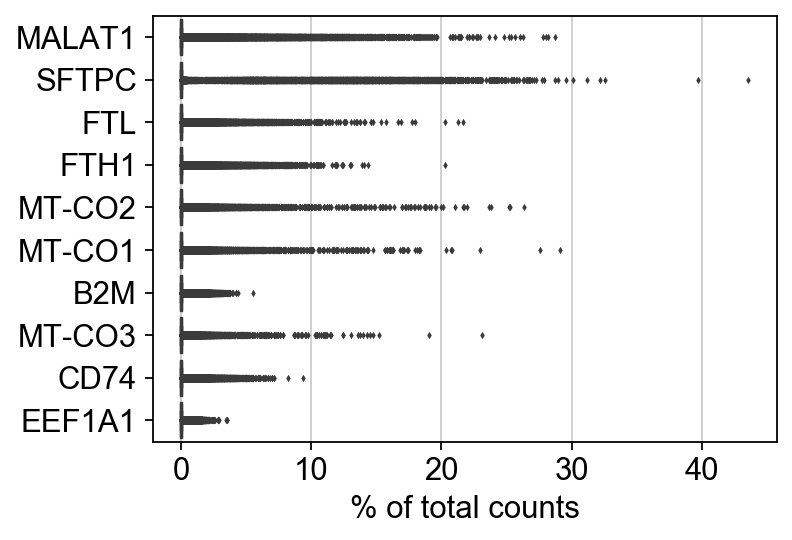

In [14]:
# p.data is the data object for use 
sc.pl.highest_expr_genes(p.data, n_top=10)

In [15]:
# QC function
# def QC(self,max_n_genes="" ,min_n_genes="",min_n_cells="",max_percent_mito="")
# scanpy tutorial QC(self,max_n_genes=2500 ,min_n_genes=200,min_n_cells=3,max_percent_mito=0.05)

p.QC(min_n_genes=200,min_n_cells=3)

filter cells
filtered out 207029 cells that have less than 200 genes expressed
filter genes
filtered out 2820 genes that are detected in less than 3 counts


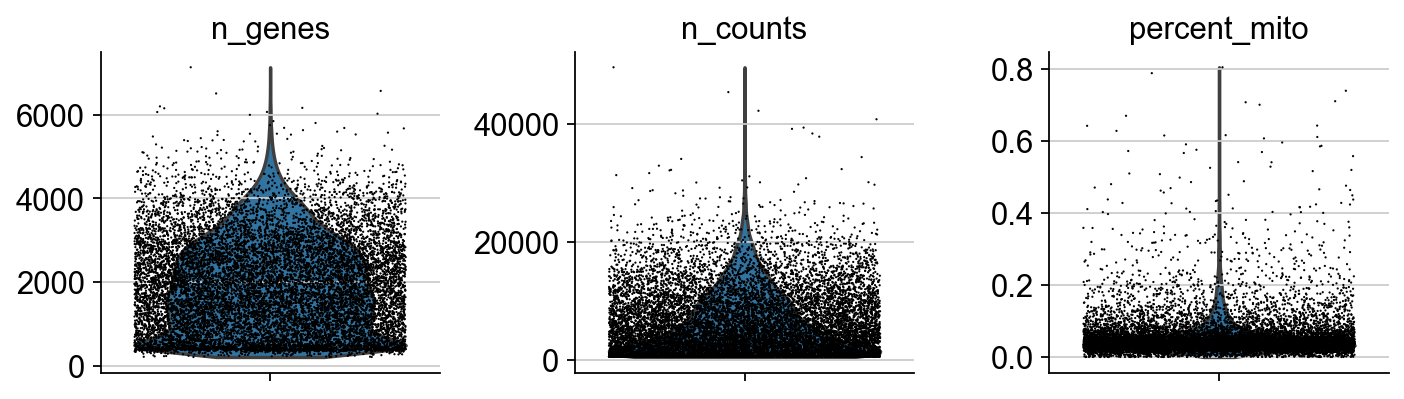

In [16]:
# plot percentage of mitochondria 
sc.pl.violin(p.data, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

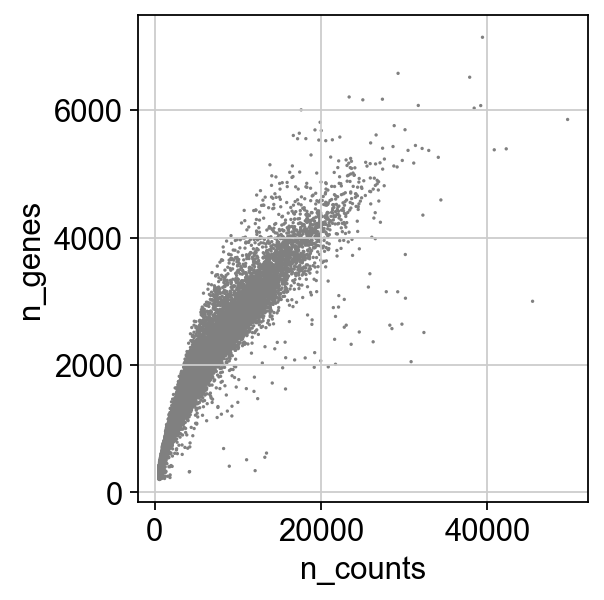

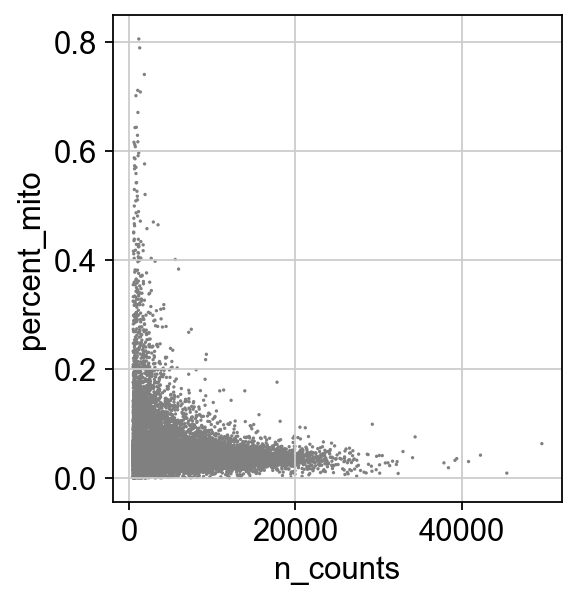

In [17]:
sc.pl.scatter(p.data, x='n_counts', y='n_genes')
sc.pl.scatter(p.data, x='n_counts', y='percent_mito')

In [18]:
# QC using percentage of mitochondria gene
p.QC(max_n_genes=5000, max_percent_mito=0.12)
"""
# for those who are more famaliar with scanpy: 
p.data = p.data[p.data.obs['n_genes'] < 5000, :]
p.data = p.data[p.data.obs['percent_mito'] < 0.12, :]
"""

filter n_genes < 5000
filter percent_mito < 0.12


"\n# for those who are more famaliar with scanpy: \np.data = p.data[p.data.obs['n_genes'] < 5000, :]\np.data = p.data[p.data.obs['percent_mito'] < 0.12, :]\n"

In [19]:
# QC process in scanpy package will remove cell barcodes. However, for database loading, we adata should keep same number of barcodes as original one. 
# We copy data from p.data to adata, which will be loaded into database   

adata = p.data.copy()

In [20]:
# normalization (library-size correct) the data matrix to 10,000 reads per cell
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [21]:
#Logarithmize the data
sc.pp.log1p(adata)

In [22]:
adata.raw = adata

In [23]:
# highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


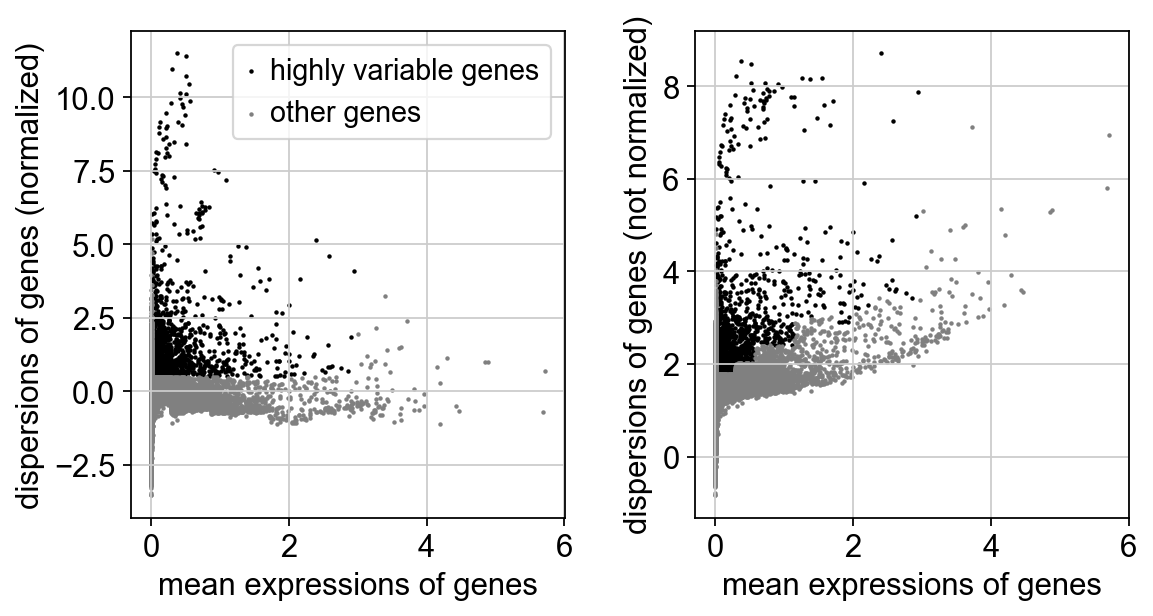

In [24]:
sc.pl.highly_variable_genes(adata)

In [25]:
adata = adata[:, adata.var['highly_variable']]
# regress out effects of total counts per cell and the percentage of mitochondrial genes.
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])
# Scale each gene to unit variance. Clip values exceeding standard deviation 10.
sc.pp.scale(adata, max_value=10)

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:26)


### Clutering - PCA, UMAP, t-SNE

##### PCA

In [26]:
# Dimention reduction: PCA as a first step
sc.tl.pca(adata, svd_solver='arpack')

computing PCA with n_comps = 50
    on highly variable genes
    finished (0:00:02)


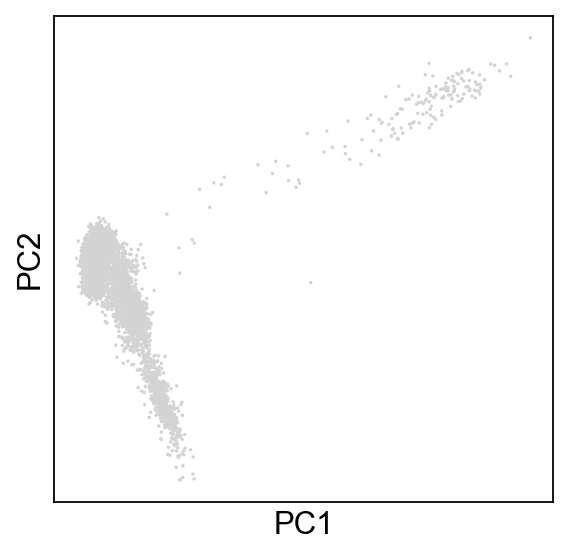

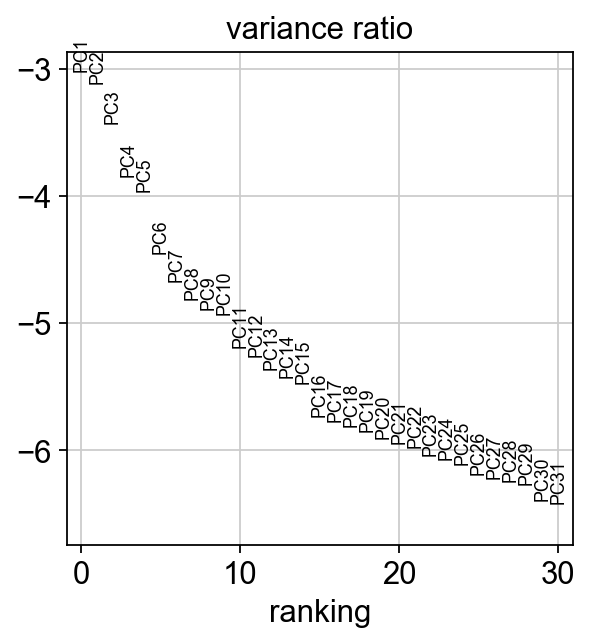

In [27]:
# PCA with out highlighting any gene
sc.pl.pca(adata)

# PCA variance ratio
sc.pl.pca_variance_ratio(adata, log=True)

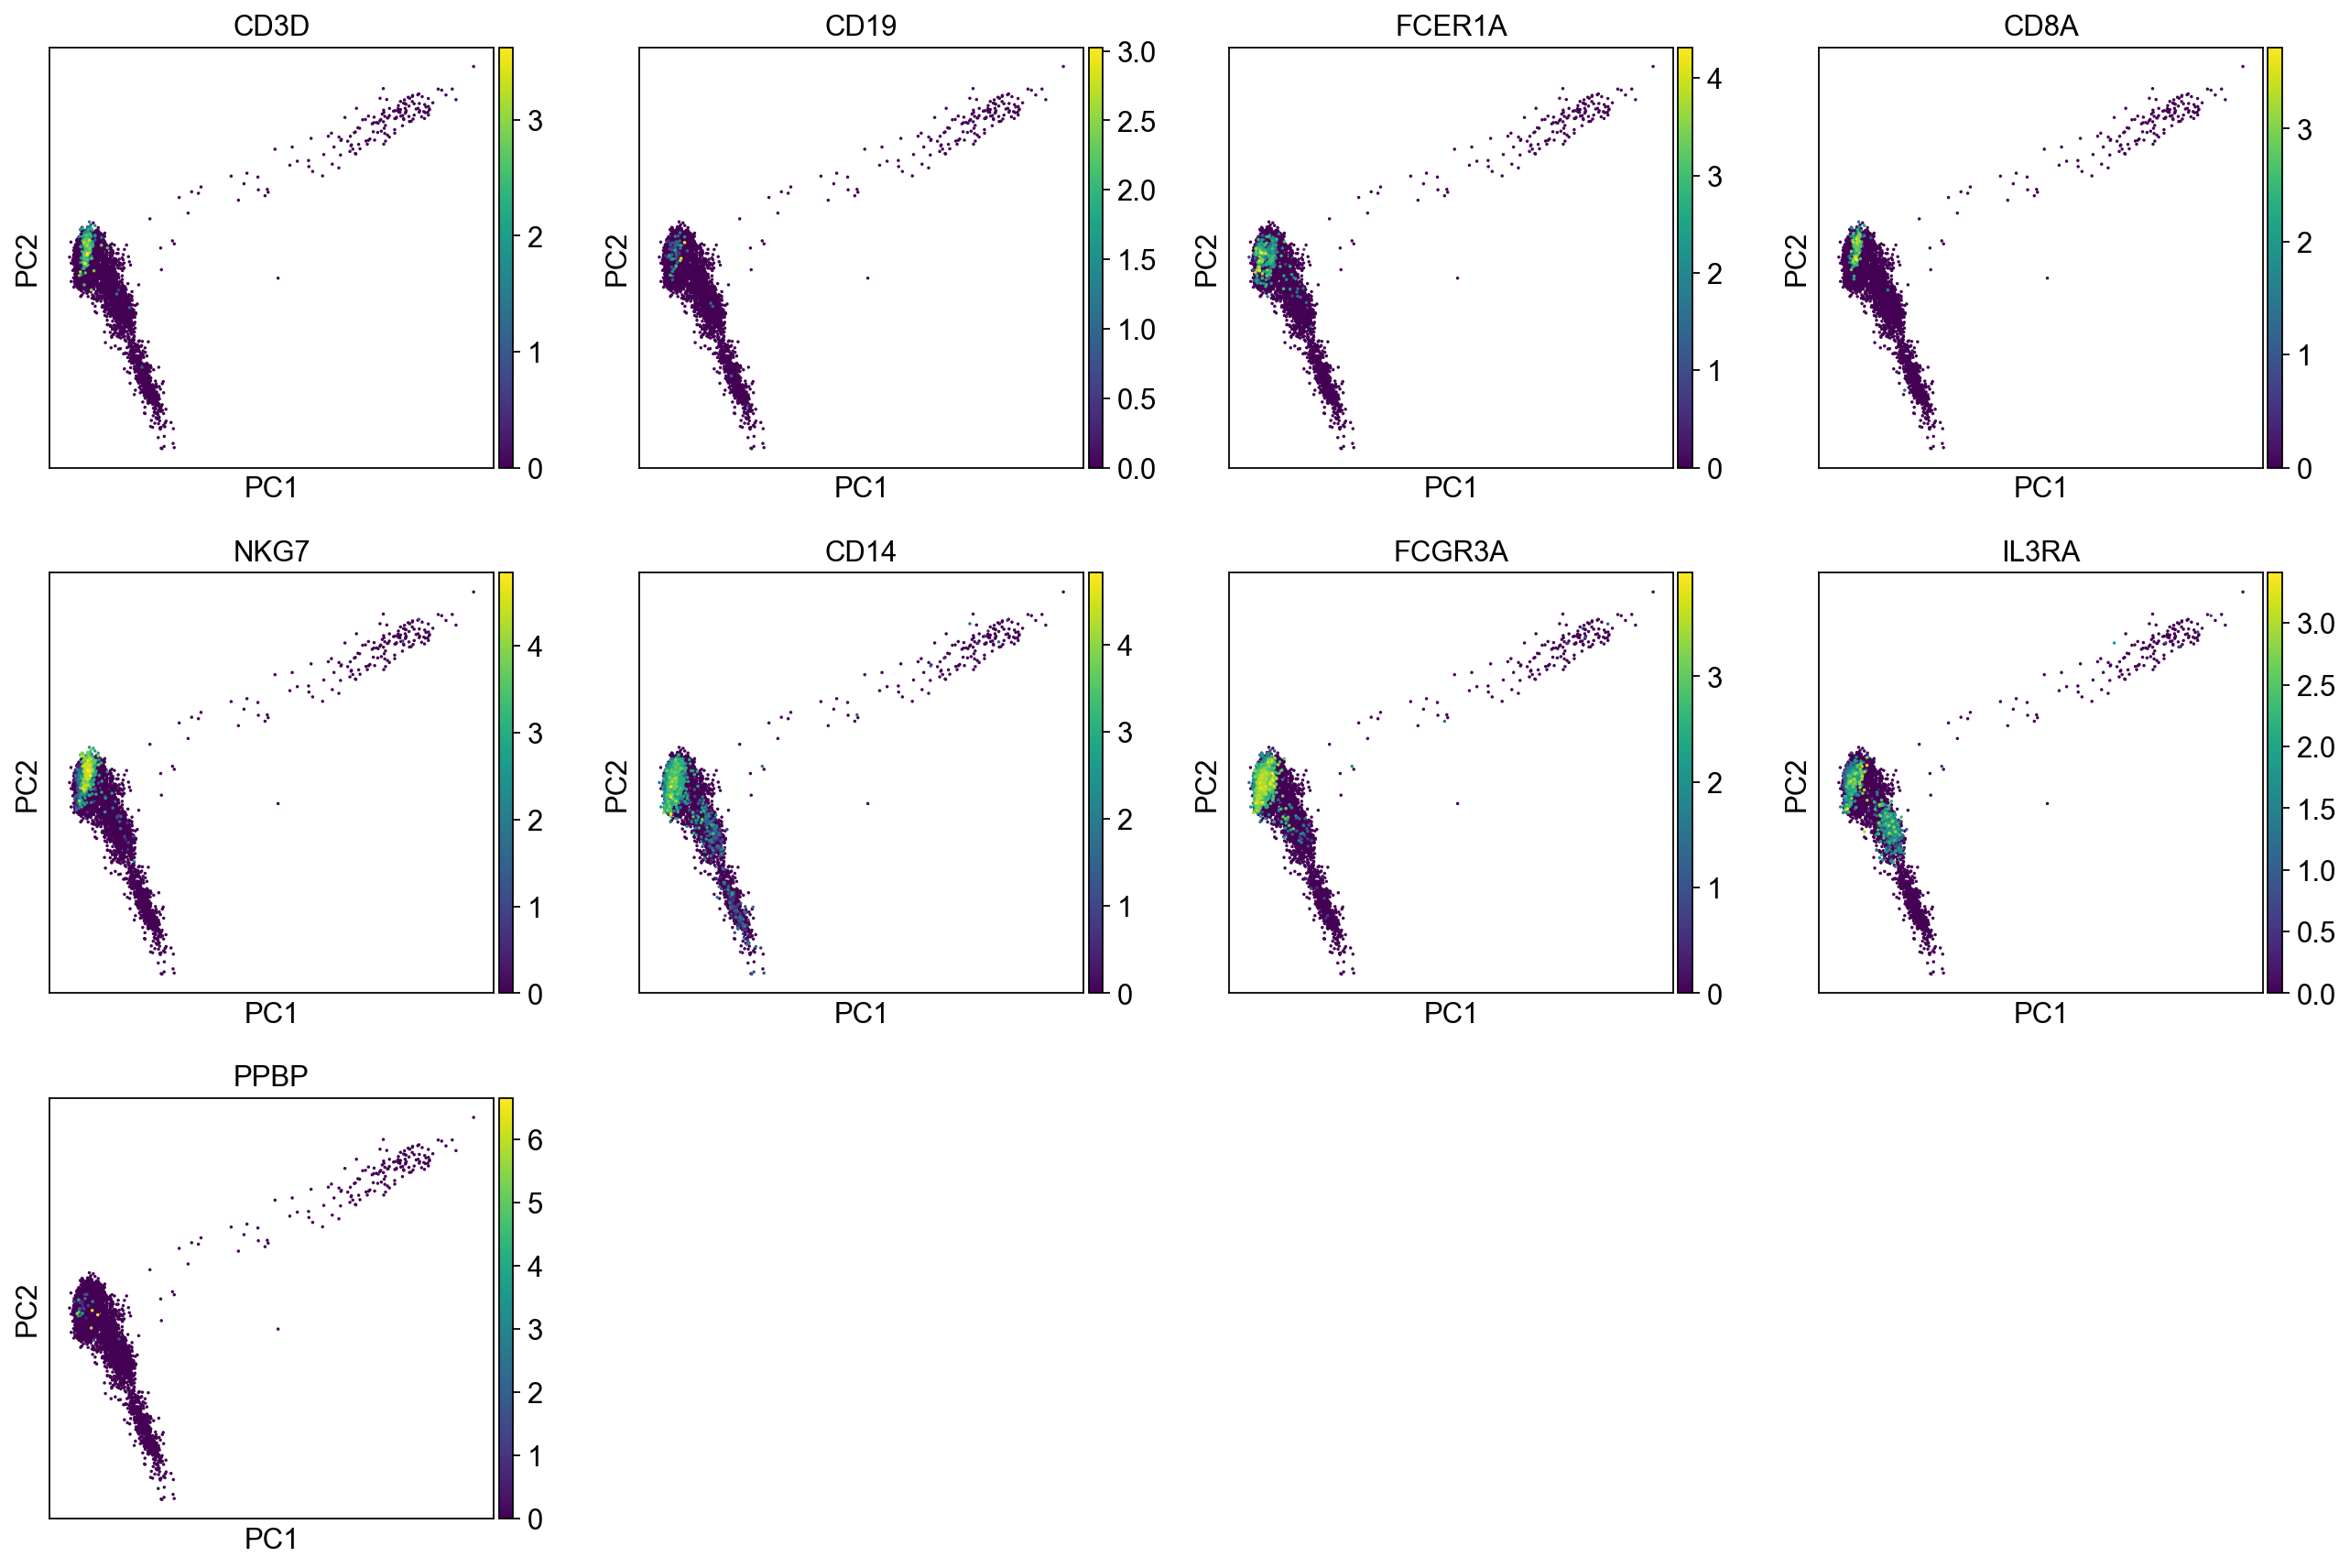

In [28]:
# You can put the genes you are interested in the color=[]
sc.pl.pca(adata, color=['CD3D','CD19','FCER1A','CD8A','NKG7','CD14','FCGR3A','IL3RA','PPBP'])

##### UMAP

In [30]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:07)


In [31]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:08)


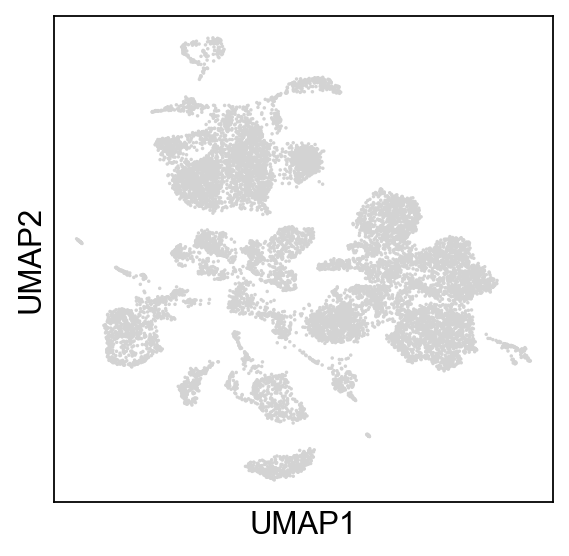

In [32]:
# umap with out highlighting any gene
sc.pl.umap(adata)

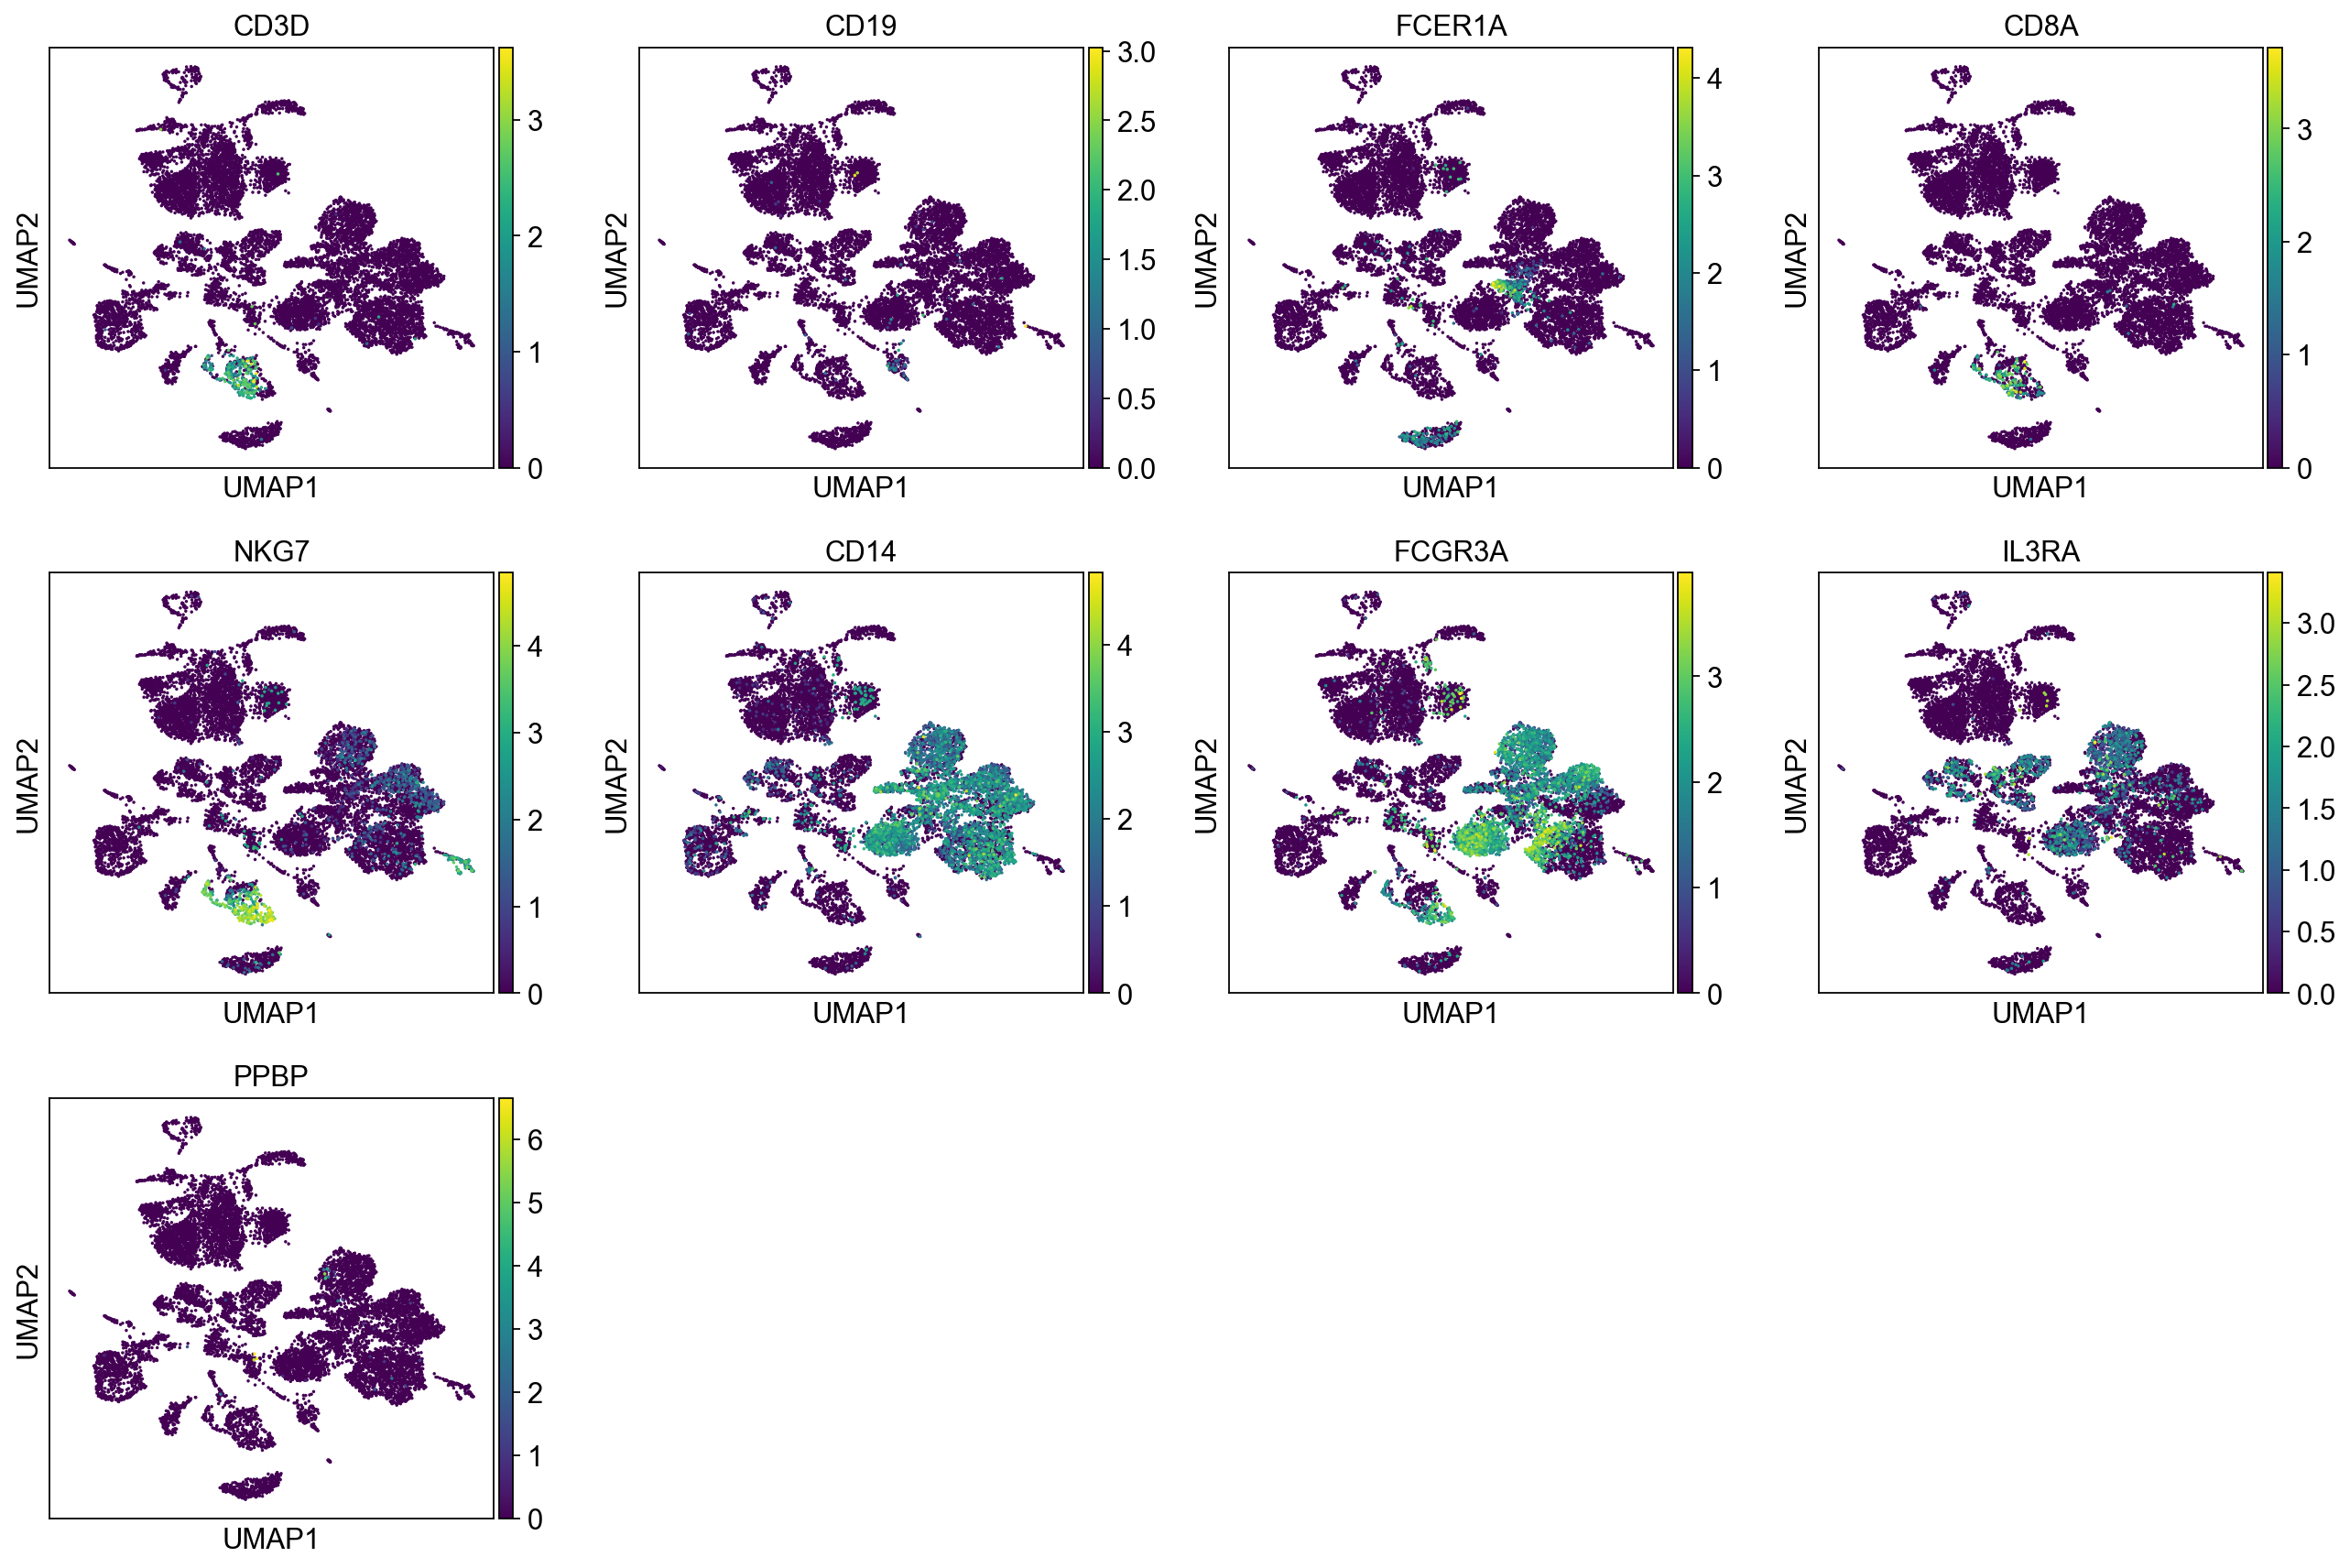

In [33]:
# You can put the genes you are interested in the color=[]
sc.pl.umap(adata, color=['CD3D','CD19','FCER1A','CD8A','NKG7','CD14','FCGR3A','IL3RA','PPBP'])

##### t-SNE

In [34]:
### t-SNE has better seperation among cell clusters, easy for single cell explorer users to lasso select cell clusters  
sc.tl.tsne(adata,n_pcs=40)

computing tSNE
    using 'X_pca' with n_pcs = 40
    using sklearn.manifold.TSNE with a fix by D. DeTomaso
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:01:00)


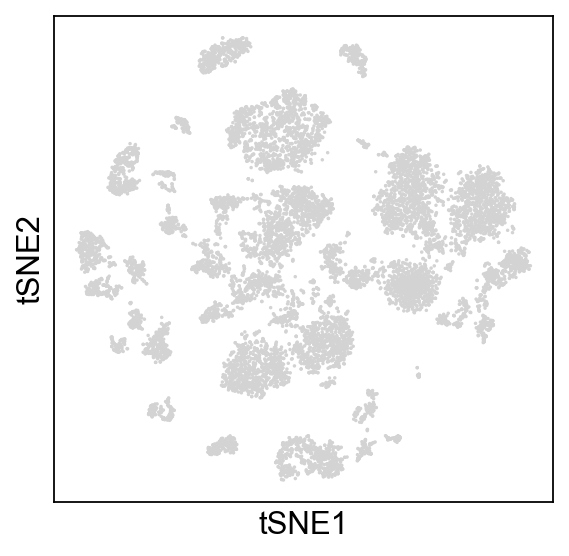

In [35]:
# umap with out highlighting any gene
sc.pl.tsne(adata)

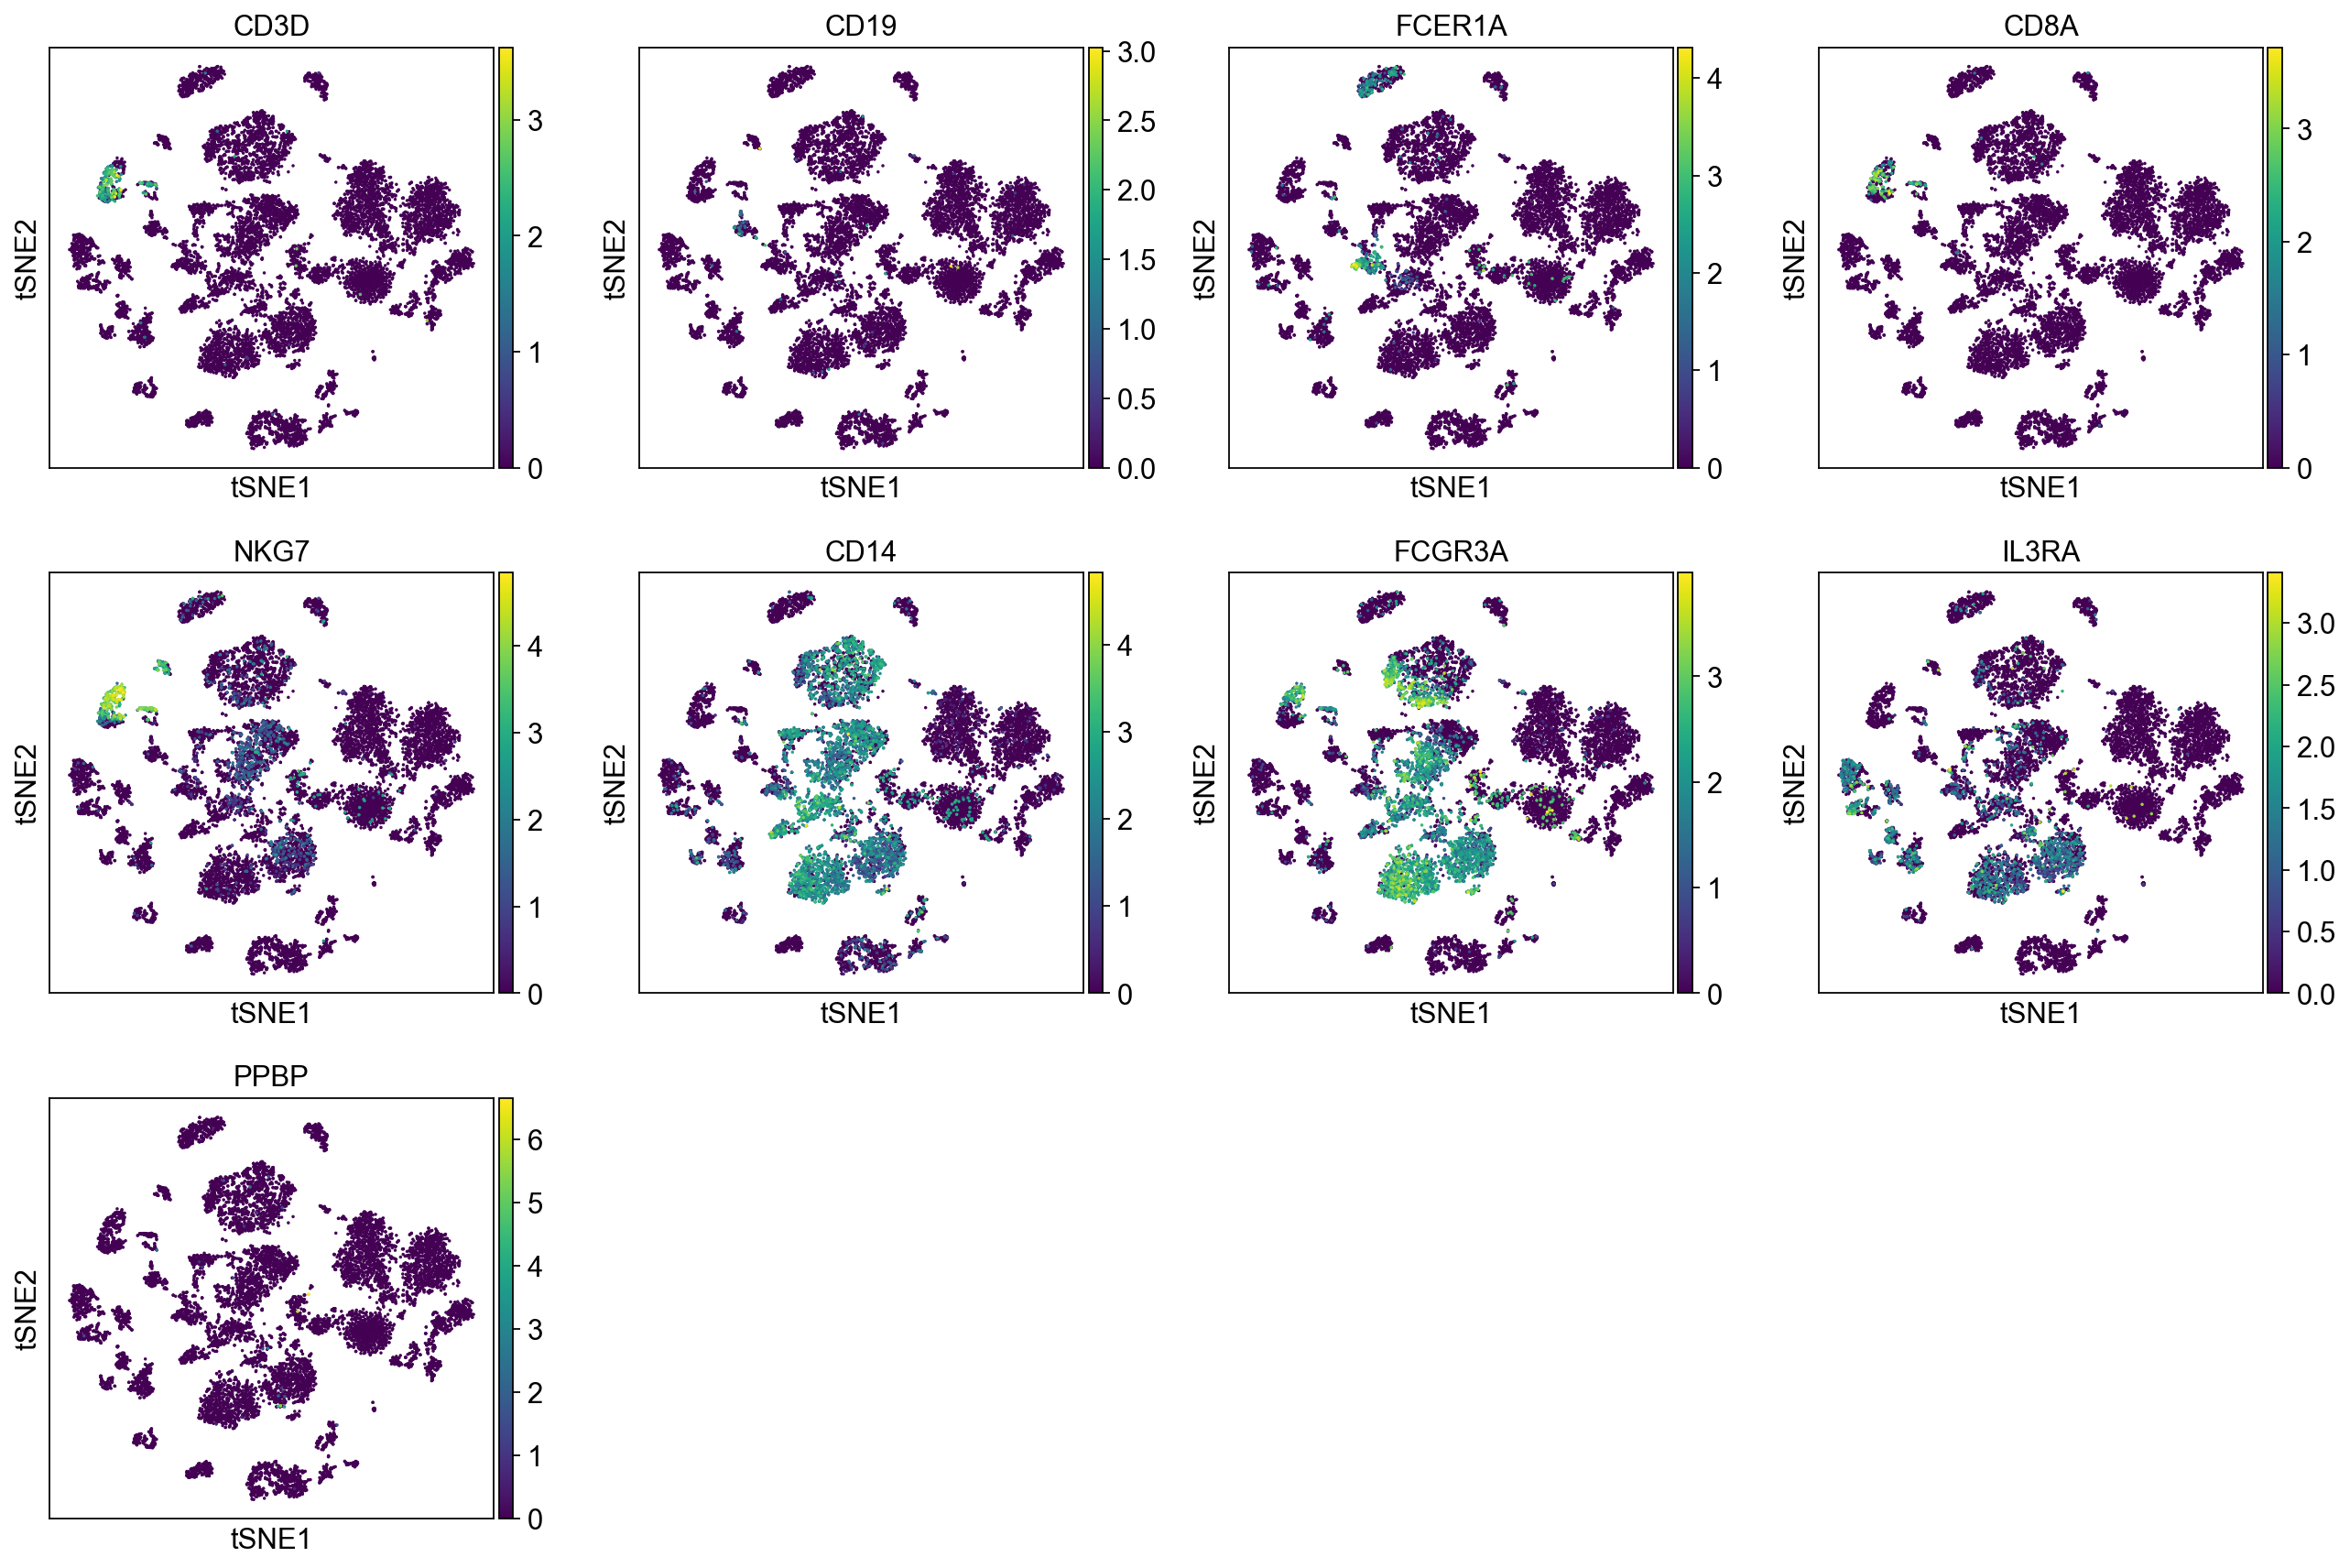

In [36]:
# You can put the genes you are interested in the color=[]
sc.pl.tsne(adata, color=['CD3D','CD19','FCER1A','CD8A','NKG7','CD14','FCGR3A','IL3RA','PPBP'], legend_loc='on data')

#### TBD - Finding marker genes

In [37]:
sc.tl.leiden(adata,resolution=0.2)

running Leiden clustering
    finished: found 19 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:02)


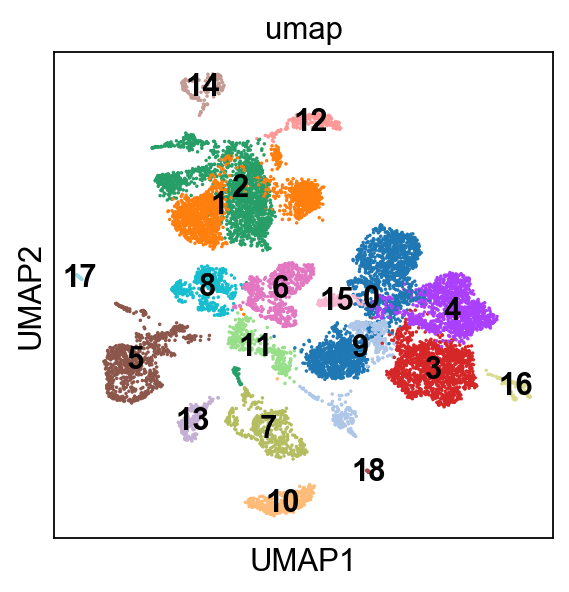

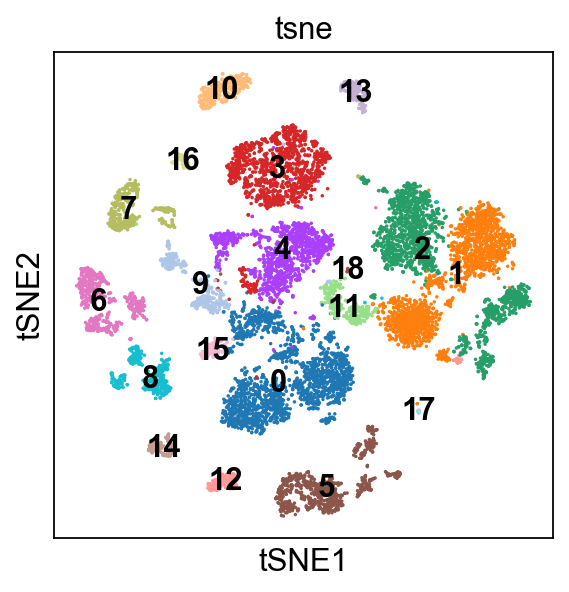

In [39]:
# visualize the leiden clustering result on umap and t-sne

sc.pl.umap(adata, color=['leiden'],legend_loc='on data',title= "umap")
sc.pl.tsne(adata, color=['leiden'],legend_loc='on data',title= "tsne")

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:05)


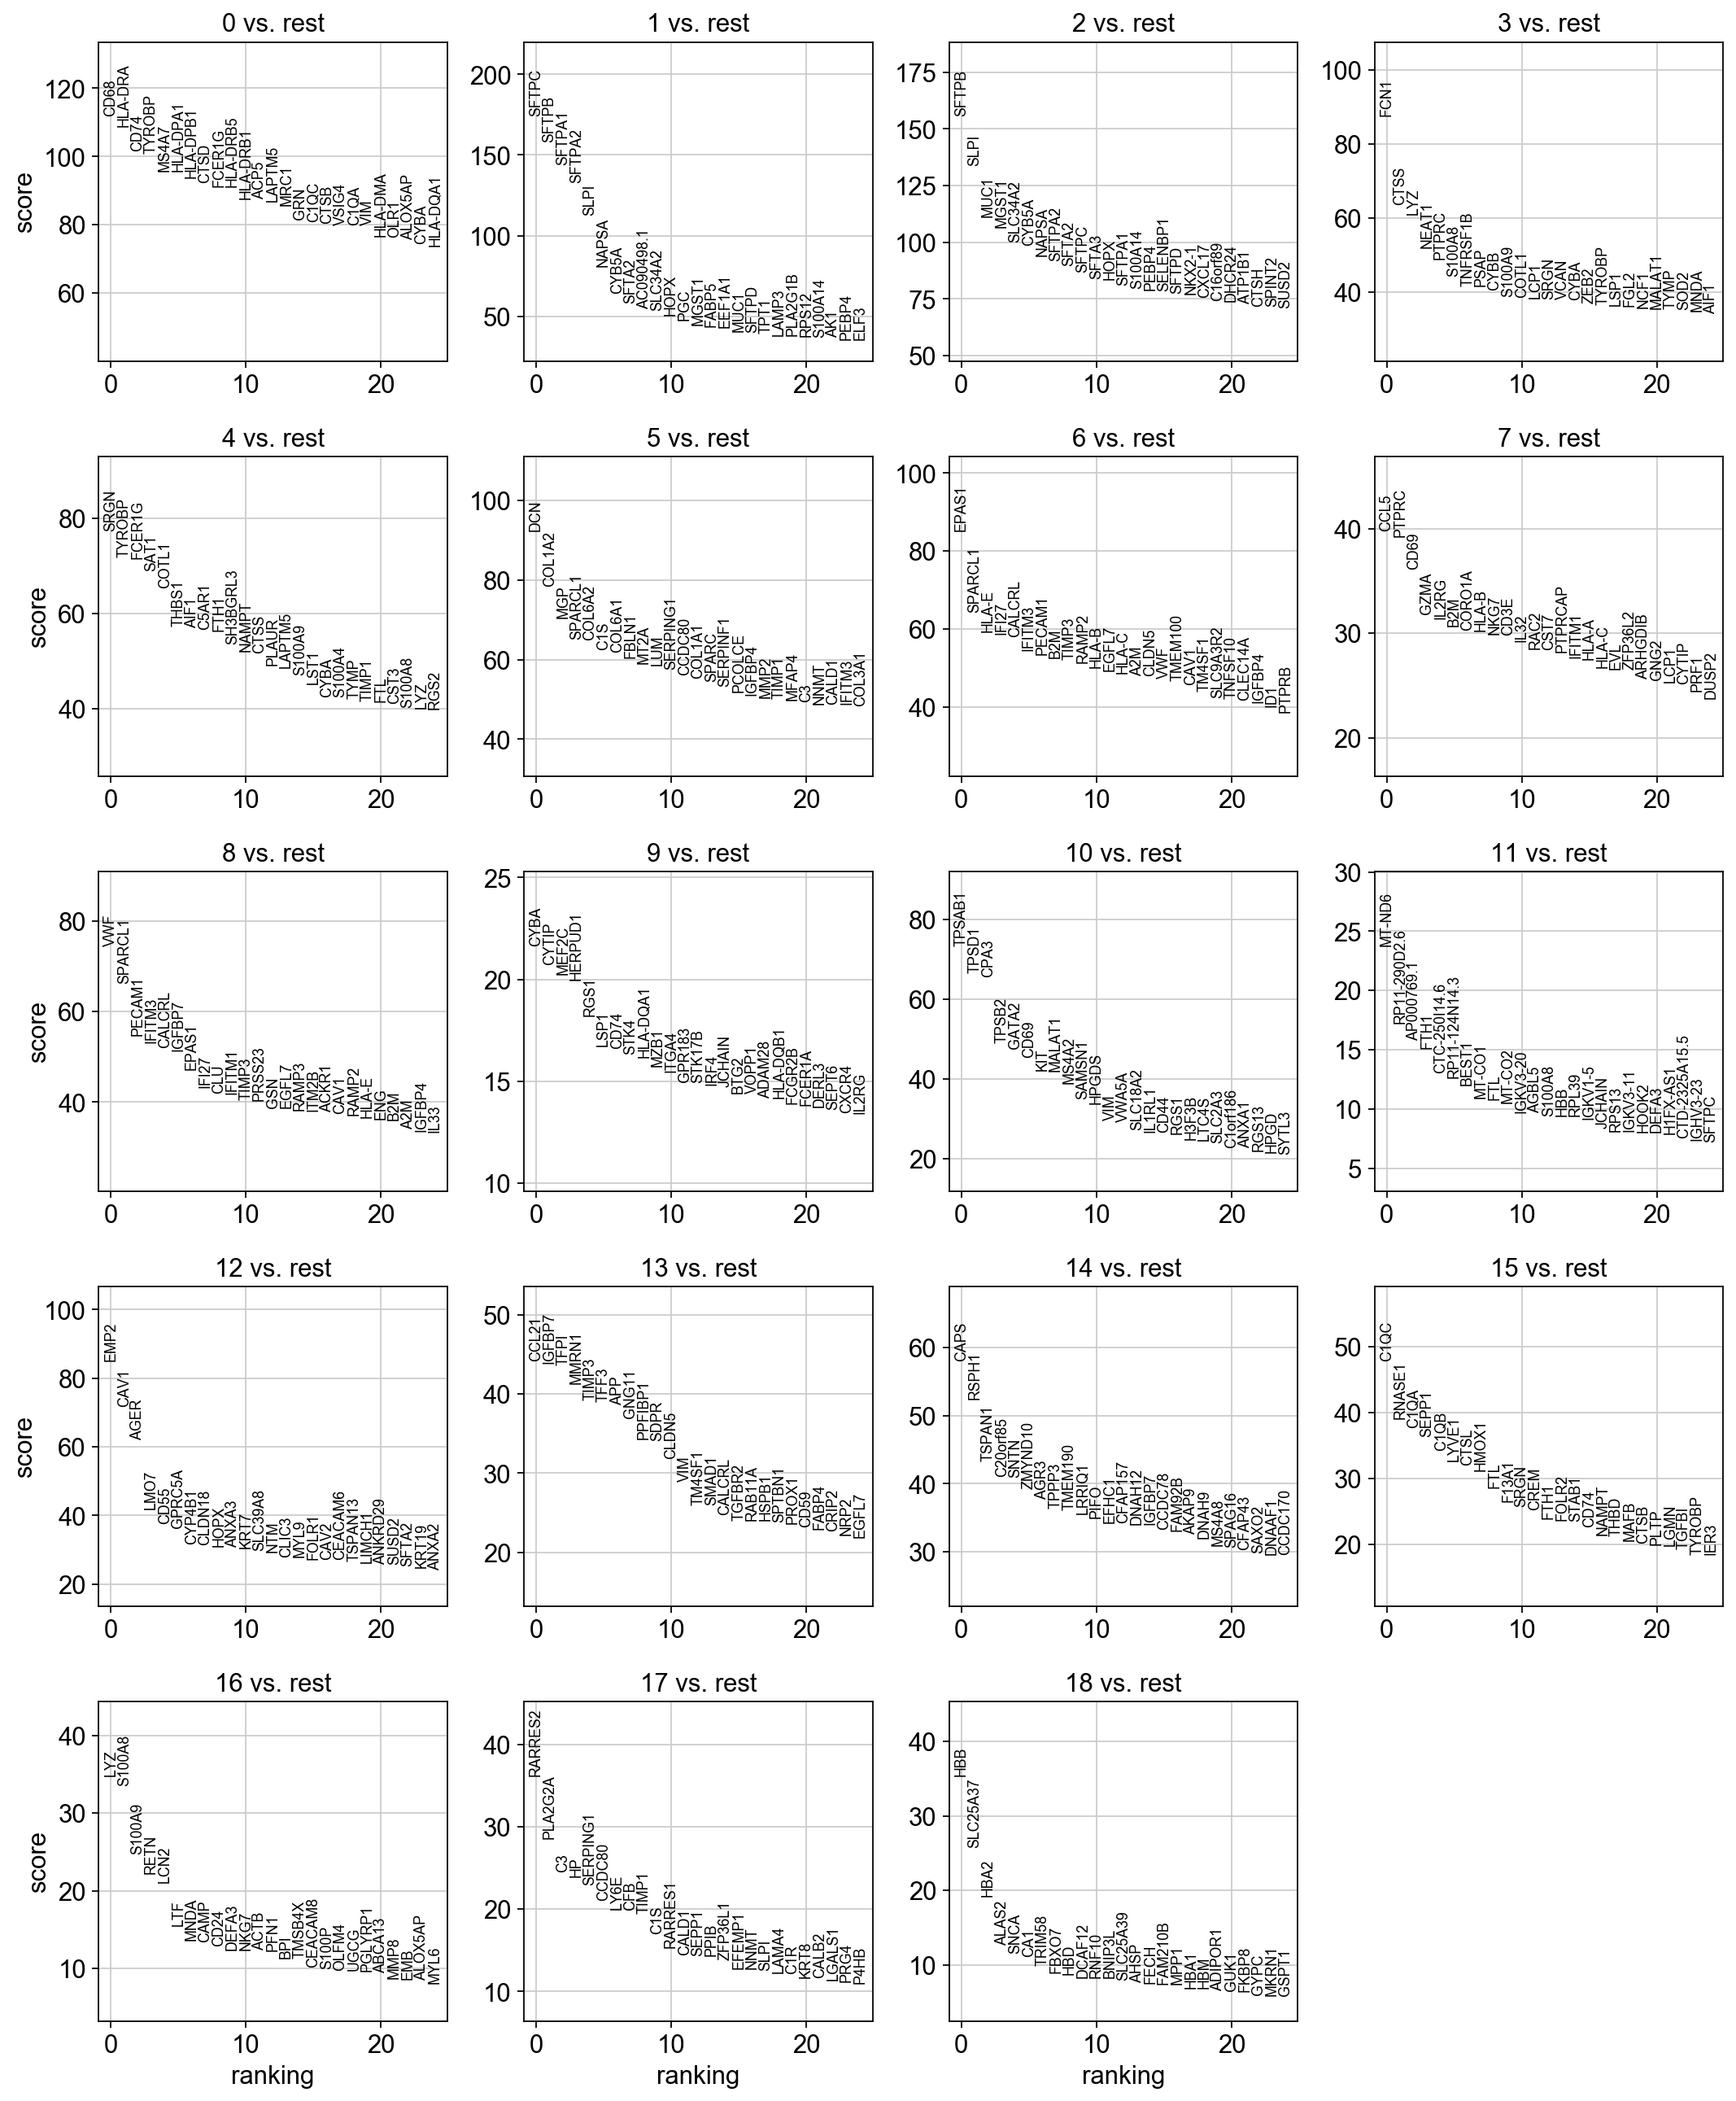

In [40]:
# Compute a ranking for the highly differential genes in each cluster (18 clusters above).

sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)